In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv("Data/clean.csv", parse_dates=True)

# 1. Nettoyage final et Indexation
# On s'assure que la date est bien l'index pour le tri chronologique
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# 2. Sélection de la feature "Close"
# On convertit en numpy array de forme (n_samples, 1)
dataset = data[['Close']].values

# 3. Normalisation (MinMax entre 0 et 1 ou -1 et 1)
# Les LSTM convergent mieux avec des données mises à l'échelle
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(dataset)

# Vérification
print(f"Forme des données normalisées : {data_scaled.shape}")

Forme des données normalisées : (5966, 1)


In [2]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# HYPERPARAMÈTRE IMPORTANT : La longueur de la séquence
# 60 jours est standard (environ 3 mois de bourse), mais peut être ajusté
SEQ_LENGTH = 60 

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(f"X shape: {X.shape}, y shape: {y.shape}")
# X shape devrait être (num_samples, 60, 1)

X shape: torch.Size([5906, 60, 1]), y shape: torch.Size([5906, 1])


In [3]:
# On garde 80% pour l'entrainement, 10% validation, 10% test
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Création des DataLoaders pour traiter par lots (batches)
BATCH_SIZE = 64

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle=False, batch_size=BATCH_SIZE)

In [4]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Définition du LSTM
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            bidirectional=True, # C'est ici que la magie opère
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Couche entièrement connectée pour la prédiction finale
        # *2 car c'est bidirectionnel
        self.fc = nn.Linear(hidden_size * 2, output_size) 
        
    def forward(self, x):
        # Initialisation des états cachés (h0, c0)
        # Forme: (num_layers * 2, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Propagation avant LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # On prend la sortie du dernier pas de temps
        # out[:, -1, :] contient les features concaténées des deux directions
        out = self.fc(out[:, -1, :])
        return out

# Configuration du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du device : {device}")

input_dim = 1      # On utilise seulement 'Close'
hidden_dim = 128   # Nombre de neurones dans la couche cachée
layer_dim = 2      # Nombre de couches LSTM empilées
output_dim = 1     # On prédit une seule valeur (le prix)

model = BiLSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

Utilisation du device : cpu


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 50
best_val_loss = float('inf')
patience = 10 # Arrêter si pas d'amélioration après 10 époques
trigger_times = 0

train_losses = []
val_losses = []

print("Démarrage de l'entraînement...")

for epoch in range(NUM_EPOCHS):
    model.train()
    batch_loss = []
    
    # Boucle d'entraînement
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    
    train_loss = np.mean(batch_loss)
    train_losses.append(train_loss)
    
    # Boucle de validation
    model.eval()
    val_batch_loss = []
    with torch.no_grad():
        for x_val_b, y_val_b in val_loader:
            x_val_b, y_val_b = x_val_b.to(device), y_val_b.to(device)
            val_out = model(x_val_b)
            v_loss = criterion(val_out, y_val_b)
            val_batch_loss.append(v_loss.item())
            
    val_loss = np.mean(val_batch_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Checkpoint : Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_bilstm_nflx.pth')
        print("  -> Meilleur modèle sauvegardé !")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

# Charger le meilleur modèle pour les tests
model.load_state_dict(torch.load('best_bilstm_nflx.pth'))

Démarrage de l'entraînement...
Epoch 1/50 | Train Loss: 0.078556 | Val Loss: 0.036414
  -> Meilleur modèle sauvegardé !
Epoch 2/50 | Train Loss: 0.043972 | Val Loss: 0.032025
  -> Meilleur modèle sauvegardé !
Epoch 3/50 | Train Loss: 0.042608 | Val Loss: 0.030187
  -> Meilleur modèle sauvegardé !
Epoch 4/50 | Train Loss: 0.041142 | Val Loss: 0.028719
  -> Meilleur modèle sauvegardé !
Epoch 5/50 | Train Loss: 0.041654 | Val Loss: 0.026856
  -> Meilleur modèle sauvegardé !
Epoch 6/50 | Train Loss: 0.040848 | Val Loss: 0.023412
  -> Meilleur modèle sauvegardé !
Epoch 7/50 | Train Loss: 0.038113 | Val Loss: 0.016303
  -> Meilleur modèle sauvegardé !
Epoch 8/50 | Train Loss: 0.047434 | Val Loss: 0.019443
Epoch 9/50 | Train Loss: 0.025224 | Val Loss: 0.019714
Epoch 10/50 | Train Loss: 0.028149 | Val Loss: 0.012486
  -> Meilleur modèle sauvegardé !
Epoch 11/50 | Train Loss: 0.019949 | Val Loss: 0.006130
  -> Meilleur modèle sauvegardé !
Epoch 12/50 | Train Loss: 0.013278 | Val Loss: 0.003991


<All keys matched successfully>

RMSE sur le test set : 6.5506


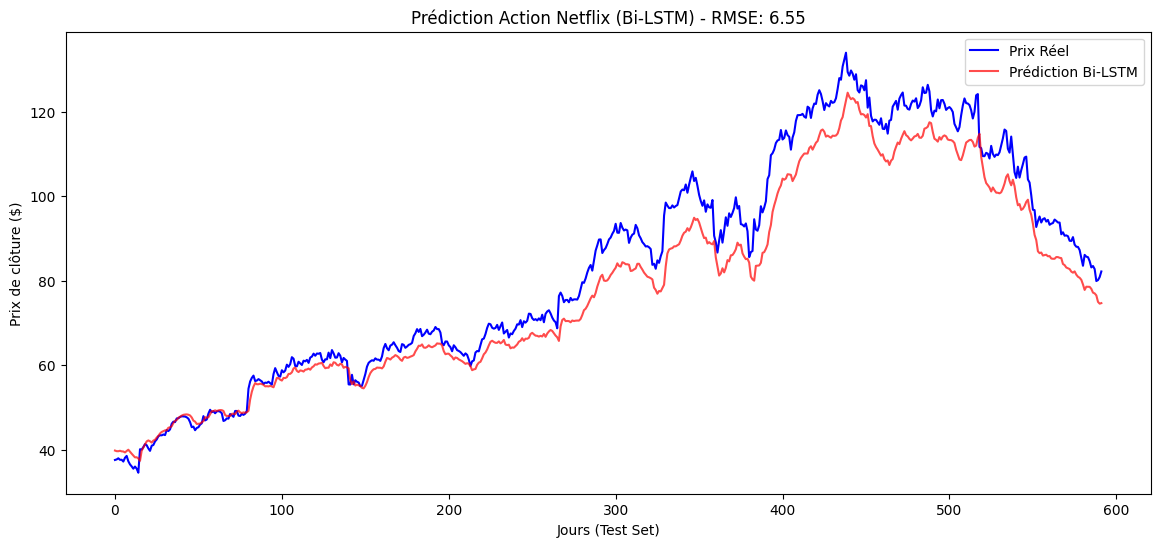

In [6]:
import matplotlib.pyplot as plt 
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x_test_b, y_test_b in test_loader:
        x_test_b = x_test_b.to(device)
        # Prédiction
        pred = model(x_test_b)
        predictions.append(pred.cpu().numpy())
        actuals.append(y_test_b.numpy())

# Concaténer tous les batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverser la transformation (MinMax)
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Calculer le RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions_inv - actuals_inv)**2))
print(f"RMSE sur le test set : {rmse:.4f}")

# Visualisation
plt.figure(figsize=(14, 6))
plt.plot(actuals_inv, label='Prix Réel', color='blue')
plt.plot(predictions_inv, label='Prédiction Bi-LSTM', color='red', alpha=0.7)
plt.title(f'Prédiction Action Netflix (Bi-LSTM) - RMSE: {rmse:.2f}')
plt.xlabel('Jours (Test Set)')
plt.ylabel('Prix de clôture ($)')
plt.legend()
plt.show()

In [7]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# On suppose que X_train, y_train, X_val, y_val sont déjà créés (comme avant)
# Note : Pour l'optimisation, on utilise souvent une SEQ_LENGTH fixe, 
# mais on peut aussi l'optimiser (cela demande de recréer le dataset à chaque essai, ce qui est long).
# Pour cet exemple, on garde SEQ_LENGTH = 60 fixé à l'étape précédente.

def objective(trial):
    # 1. DÉFINITION DE L'ESPACE DE RECHERCHE (Les plages de test)
    
    # Nombre de neurones : entre 32 et 256
    hidden_size = trial.suggest_int('hidden_size', 32, 256) 
    
    # Nombre de couches LSTM : 1, 2 ou 3
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    # Dropout : entre 0.1 et 0.5
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    
    # Learning Rate : échelle logarithmique (0.0001 à 0.01)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    # Choix de l'optimiseur (Adam ou RMSprop)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])

    # 2. CRÉATION DU MODÈLE AVEC CES PARAMÈTRES
    model = BiLSTMModel(input_size=1, 
                        hidden_size=hidden_size, 
                        num_layers=num_layers, 
                        output_size=1, 
                        dropout=dropout).to(device)

    # Définition de l'optimiseur dynamique
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        
    criterion = nn.MSELoss()

    # 3. ENTRAÎNEMENT RAPIDE (BOUCLE RÉDUITE)
    # On peut réduire le nombre d'époques pour la recherche (ex: 10 ou 20)
    # pour aller plus vite, car un mauvais modèle se voit vite.
    MAX_EPOCHS_SEARCH = 15 
    
    for epoch in range(MAX_EPOCHS_SEARCH):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(x_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred = model(x_val)
                loss = criterion(pred, y_val)
                val_losses.append(loss.item())
        
        avg_val_loss = sum(val_losses) / len(val_losses)

        # PRUNING (ELAGAGE)
        # Si le modèle est très mauvais dès le début, Optuna l'arrête tout de suite
        # pour ne pas perdre de temps.
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # On retourne la perte finale de validation (ce qu'on veut minimiser)
    return avg_val_loss

/home/yann/.pyenv/versions/Pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# On crée l'étude (direction='minimize' car on veut réduire la Loss)
study = optuna.create_study(direction='minimize')

print("Début de l'optimisation des hyperparamètres...")
# n_trials=50 signifie qu'on va tester 50 combinaisons différentes
study.optimize(objective, n_trials=50)

# Affichage des résultats
print("------------------------------------------------")
print("MEILLEURS PARAMÈTRES TROUVÉS :")
print(study.best_params)
print(f"Meilleure Val Loss : {study.best_value}")
print("------------------------------------------------")

[I 2026-02-07 12:25:20,268] A new study created in memory with name: no-name-5db55db1-f822-4ed1-ab5e-dc2fcd72339a


Début de l'optimisation des hyperparamètres...


[I 2026-02-07 12:25:29,570] Trial 0 finished with value: 0.0007001389996730723 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.12244958292735056, 'lr': 0.002459392836311585, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.0007001389996730723.
[I 2026-02-07 12:26:39,722] Trial 1 finished with value: 0.005828870966797695 and parameters: {'hidden_size': 237, 'num_layers': 1, 'dropout': 0.38469489192344253, 'lr': 0.0004924740275228273, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.0007001389996730723.
[I 2026-02-07 12:27:47,313] Trial 2 finished with value: 0.03620527142775245 and parameters: {'hidden_size': 246, 'num_layers': 1, 'dropout': 0.22726566737928944, 'lr': 0.0008511247393923299, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.0007001389996730723.
[I 2026-02-07 12:27:53,554] Trial 3 finished with value: 0.004212157425354235 and parameters: {'hidden_size': 59, 'num_layers': 1, 'dropout': 0.4286289217996472, 'lr': 0.004299057766944619, 'optimiz

------------------------------------------------
MEILLEURS PARAMÈTRES TROUVÉS :
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0.12244958292735056, 'lr': 0.002459392836311585, 'optimizer': 'Adam'}
Meilleure Val Loss : 0.0007001389996730723
------------------------------------------------


In [9]:
# Récupération des meilleurs hyperparamètres
best_params = study.best_params

final_model = BiLSTMModel(
    input_size=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=1,
    dropout=best_params['dropout']
).to(device)

# Recréer l'optimiseur avec le meilleur learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
else:
    optimizer = optim.RMSprop(final_model.parameters(), lr=best_params['lr'])

train_losses = []
val_losses = []

NUM_EPOCHS = 70
best_val_loss = float('inf')
patience = 10 
trigger_times = 0

print("Démarrage de l'entraînement...")

for epoch in range(NUM_EPOCHS):
    model.train()
    batch_loss = []
    
    # Boucle d'entraînement
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    
    train_loss = np.mean(batch_loss)
    train_losses.append(train_loss)
    
    # Boucle de validation
    model.eval()
    val_batch_loss = []
    with torch.no_grad():
        for x_val_b, y_val_b in val_loader:
            x_val_b, y_val_b = x_val_b.to(device), y_val_b.to(device)
            val_out = model(x_val_b)
            v_loss = criterion(val_out, y_val_b)
            val_batch_loss.append(v_loss.item())
            
    val_loss = np.mean(val_batch_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Checkpoint : Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_bilstm_nflx.pth')
        print("  -> Meilleur modèle sauvegardé !")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

# Charger le meilleur modèle pour les tests
model.load_state_dict(torch.load('best_bilstm_nflx.pth'))

Démarrage de l'entraînement...
Epoch 1/70 | Train Loss: 0.018118 | Val Loss: 0.001723
  -> Meilleur modèle sauvegardé !
Epoch 2/70 | Train Loss: 0.018158 | Val Loss: 0.001723
Epoch 3/70 | Train Loss: 0.018204 | Val Loss: 0.001723
Epoch 4/70 | Train Loss: 0.018243 | Val Loss: 0.001723
Epoch 5/70 | Train Loss: 0.018182 | Val Loss: 0.001723
Epoch 6/70 | Train Loss: 0.018312 | Val Loss: 0.001723
Epoch 7/70 | Train Loss: 0.018217 | Val Loss: 0.001723
Epoch 8/70 | Train Loss: 0.018198 | Val Loss: 0.001723
Epoch 9/70 | Train Loss: 0.018237 | Val Loss: 0.001723
Epoch 10/70 | Train Loss: 0.018139 | Val Loss: 0.001723
Epoch 11/70 | Train Loss: 0.018250 | Val Loss: 0.001723
Early stopping à l'époque 11


<All keys matched successfully>

RMSE sur le test set : 6.5506


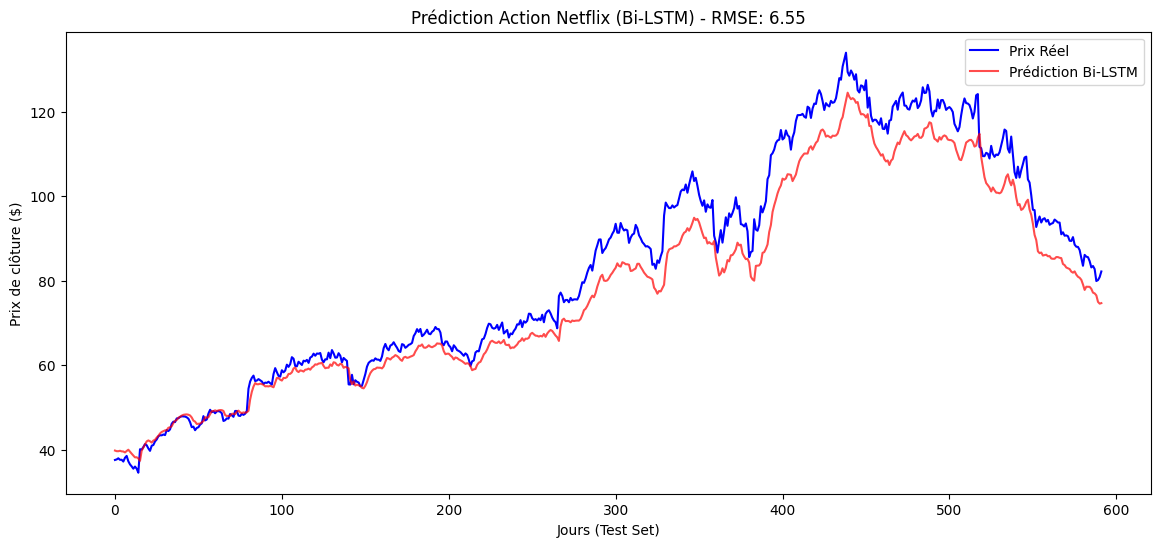

In [10]:
import matplotlib.pyplot as plt 
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x_test_b, y_test_b in test_loader:
        x_test_b = x_test_b.to(device)
        # Prédiction
        pred = model(x_test_b)
        predictions.append(pred.cpu().numpy())
        actuals.append(y_test_b.numpy())

# Concaténer tous les batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverser la transformation (MinMax)
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Calculer le RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions_inv - actuals_inv)**2))
print(f"RMSE sur le test set : {rmse:.4f}")

# Visualisation
plt.figure(figsize=(14, 6))
plt.plot(actuals_inv, label='Prix Réel', color='blue')
plt.plot(predictions_inv, label='Prédiction Bi-LSTM', color='red', alpha=0.7)
plt.title(f'Prédiction Action Netflix (Bi-LSTM) - RMSE: {rmse:.2f}')
plt.xlabel('Jours (Test Set)')
plt.ylabel('Prix de clôture ($)')
plt.legend()
plt.show()